# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
from ydata_profiling import ProfileReport
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_actual_vs_prediction, plot_residual
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from xgboost import XGBRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor

%matplotlib inline
pd.options.display.max_columns = 200

In [2]:
# Load data
data = pd.read_csv('the_office.csv')
df_guest_star = pd.read_csv('guest_duration_office.csv')

In [3]:
# ProfileReport(data)

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In [4]:
def data_preparation(data, df_guest_star):
    """
    Feature engineering for training and to-be-predicted data.
  
    Parameters
    ----------
    df_credit: Pandas dataframe of raw data (pd.DataFrame).
    future: Identifier for training or to-be-predicted data (boolean).
  
    Returns
    -------
    df: Pandas dataframe of data with appropriate features (pd.DataFrame).
    """
    df = data.copy()
    
    # Clean director data
    clean_director = {'McDougal':'McDougall',
                      'Scanlong':'Scanlon',
                      'Daneils':'Daniels',
                      'Wittingham': 'Whittingham',
                      'Lieerstein': 'Lieberstein'
                     }
    df['director'] = df['director'].replace(clean_director)
    
    # Retrieve guest star in each episode, Separate ; into columns then apply one hot encoding for writer and main chars
    df_guest_star = df_guest_star.rename(columns={'Season':'season', 'EpisodeTitle':'episode_name', 'GuestStars':'guest_stars'})
    df = df.merge(df_guest_star[['season', 'episode_name', 'guest_stars']],
                    how='left', on=['season', 'episode_name'])
    
    # Convert air_date column from string to datetime
    df['air_date'] = pd.to_datetime(df['air_date'], format='%Y-%m-%d')
    
    # Retrieve day, month, year, week of year, day of week, weekday/weekend
#     df['air_day'] = df['air_date'].dt.day
    df['air_month'] = df['air_date'].dt.month
#     df['air_year'] = df['air_date'].dt.year
#     df['air_week'] = df['air_date'].dt.isocalendar().week
#     df['air_day_of_week'] = df['air_date'].dt.weekday
#     df['air_is_weekday'] = df['air_date'].apply(lambda x: 1 if x.weekday() < 5 else 0)
    
    # Separate ; into columns then apply one hot encoding for writer, main_chars, and guest
#     mlb = MultiLabelBinarizer()
    for key, val in {'writer':'w', 'main_chars':'mc', 'guest_stars':'gs'}.items():
        df[key] = df[key].fillna('N/A')
        df[key] = df[key].str.split(';') if key != 'guest_stars' else df[key].str.split(',')
#         mlb.fit(df[key])
#         df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df[key]), columns=val+'_'+mlb.classes_)], axis=1)
    
    # Count the number of writer and main_chars
    for col in ['writer', 'main_chars', 'guest_stars']:
        df[col + '_count'] = df[col].apply(lambda x: len(x) if x[0] != 'N/A' else 0)
    
    # Retrieve episode count by director
    df['ep_count_director'] = df.apply(lambda x: df[(df['director'] == x['director']) & (df['air_date'] < x['air_date'])].episode.count(),
                                                    axis=1)
    
    # Avg, min, and max rating by director
    df['avg_votes_director'] = df.apply(lambda x: df[(df['director'] == x['director']) & (df['air_date'] < x['air_date'])].total_votes.mean(),
                                                    axis=1)
    df['min_votes_director'] = df.apply(lambda x: df[(df['director'] == x['director']) & (df['air_date'] < x['air_date'])].total_votes.min(),
                                                    axis=1)
    df['max_votes_director'] = df.apply(lambda x: df[(df['director'] == x['director']) & (df['air_date'] < x['air_date'])].total_votes.max(),
                                                    axis=1)
    
    # Rating from previous episode
    df['imdb_rating_prev'] = df['imdb_rating'].shift(1)
    
    # Length of each episode name
    df['episode_name_length'] = df['episode_name'].str.len()
    
    
    # Drop irrelevant columns columns
#     df = df.drop(columns=['episode', 'air_date', 'writer', 'main_chars', 'guest_stars'])
    df = df.drop(columns=['air_date'])
  
    return df

In [5]:
def preprocess(num_cols, cat_cols):
    """
    Preprocess data by imputing null values and one hot encoding categorical columns.
  
    Arguments
    ---------
    impute: {'knn', 'mean', 'median', None}
            type of imputation

    scaling: {'standard', 'minmax', 'robust', None}
             type of scaling

    transform: {'yeo-johnson', 'box-cox', None}
               type of power transformer

    poly: int or None
          if int is specified, it specifies the polynomial degree

    memory: None or str
            Providing path string enables scikit-learn's pipeline caching.
            See scikit-learn pipeline documentation for more info
  
    Returns
    -------
    sklearn Pipeline
    """
    
    preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson', impute='knn'),
     num_cols),
    ('categoric', cat_pipe(encoder='onehot'),
     cat_cols)
    ])

    pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(random_state=42))
    ])
  
    return pipeline

In [6]:
def split(df):
    """
    Split data to training and testing.

    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    
    Returns
    -------
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    """
    
    X = df.drop(columns=['imdb_rating'])
    y = df['imdb_rating']
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [7]:
def hyperparameter_tuning(pipeline, X_train, X_test, y_train, y_test):
    """
    Hyperparameter tuning using randomized search to identify the best parameters.
    
    Parameters
    ----------
    pipeline: sklearn pipeline
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn model).
    """
  
    # Run model
    # Randomized search of parameters, using 3 fold cross validation
    params = {
#               "algo__min_samples_split": Integer(2,20),
              "algo__n_estimators": Integer(100, 200),
#               "algo__max_depth": Integer(20, 80),
#               "algo__max_features": Real(0.1, 1),
#               "algo__min_samples_leaf": Integer(1, 20)
            }
    
    model = RandomizedSearchCV(pipeline, params,
                               scoring='r2', n_iter=30, random_state=42,
                               cv=3, verbose=2, n_jobs=-1)

    # Fit the randomized search model
    model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    y_pred = best_estimator.predict(X_train)
    print('R2 Score (Train): {}'.format(r2_score(y_train, y_pred)))
    # print('R2 Score (Train): {}'.format(model.best_score_))

    # Evaluation metrics
    y_pred = best_estimator.predict(X_test)
    print('R2 Score: {}'.format(r2_score(y_test, y_pred)))
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

    # Plot R2 Score and Residual
    plot_actual_vs_prediction(X_train, y_train, X_test, y_test, best_estimator)
    plot_residual(X_train, y_train, X_test, y_test, best_estimator)
  
    return best_estimator

In [8]:
def feature_importance(model, X_train, y_train):
    """
    Calculate mean score decrease (feature importance) of each feature. Mean score decrease perform a random permutation on each of the input columns then collects the score decrease caused by each columns.
  
    Parameters
    ----------
    model: Model from hyperparameter tuning (model).
    X_train: Training dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
  
    Returns
    -------
    df_feature: Pandas dataframe consists of top n feature (pd.DataFrame).
    """
  
    # Check Feature Importance
    feature_importances = mean_score_decrease(X_train, y_train, best_estimator, plot=True, topk=10, normalize=True)
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)[['feature', 'importance']].reset_index(drop=True)
  
    # Show feature importance table
    display(feature_importances)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Best Parameters: {'algo__n_estimators': 102}
R2 Score (Train): 0.9386934546256352
R2 Score: 0.6584548220639737
RMSE: 0.25842444005485093
MAE: 0.2113970588235288


,feature,importance
0,total_votes,0.758656
1,n_words,0.047156
2,min_votes_director,0.046334
3,n_lines,0.029255
4,avg_votes_director,0.028024
5,max_votes_director,0.025239
6,n_directions,0.015460
7,n_speak_char,0.014193
8,imdb_rating_prev,0.012315
9,main_chars_count,0.011038


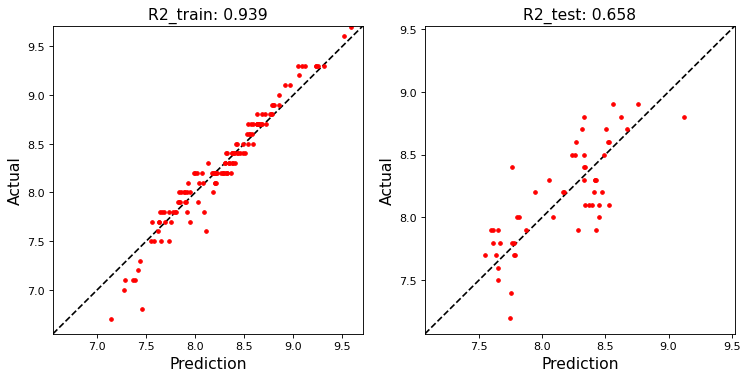

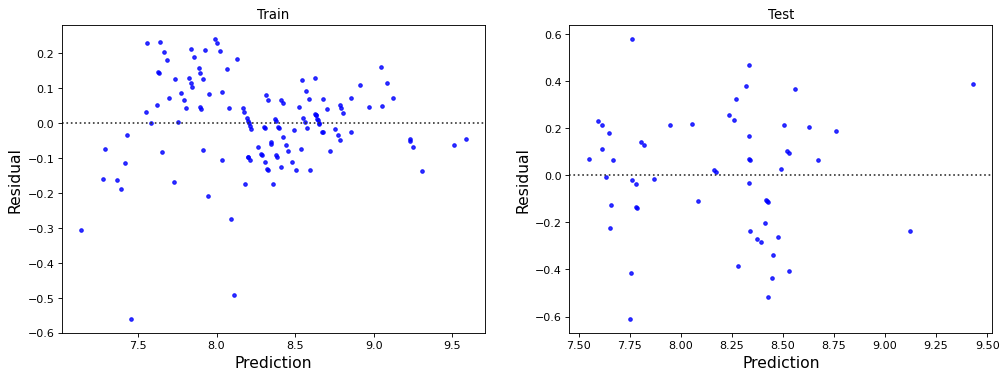

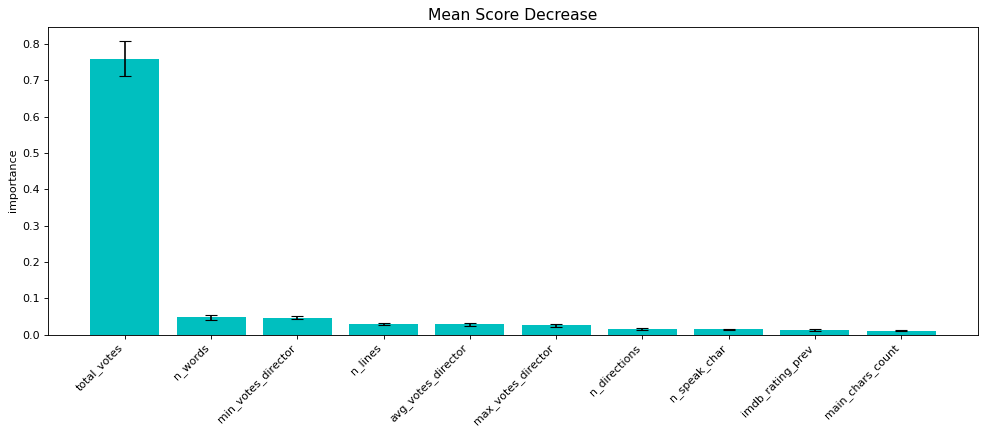

In [9]:
num_cols = ['total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'ep_count_director',
            'writer_count', 'main_chars_count', 'imdb_rating_prev', 'avg_votes_director', 'min_votes_director',
            'max_votes_director']
cat_cols = []

df = data_preparation(data, df_guest_star)
pipeline = preprocess(num_cols, cat_cols)
X_train, X_test, y_train, y_test = split(df)
best_estimator = hyperparameter_tuning(pipeline, X_train, X_test, y_train, y_test)
df_feature = feature_importance(best_estimator, X_train, y_train)

In [10]:
# ProfileReport(df[[
#                 'total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'ep_count_director',
#                 'writer_count', 'main_chars_count', 'imdb_rating_prev', 'avg_votes_director', 'min_votes_director',
#                 'max_votes_director',
#                 'air_day', 'air_month', 'air_year', 'air_week', 'air_day_of_week', 'air_is_weekday']])

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

In [11]:
# px.line(data, x='air_date', y='imdb_rating')

[CV] END .............................algo__n_estimators=151; total time=   0.3s
[CV] END .............................algo__n_estimators=171; total time=   0.3s
[CV] END .............................algo__n_estimators=120; total time=   0.2s
[CV] END .............................algo__n_estimators=174; total time=   0.3s
[CV] END .............................algo__n_estimators=199; total time=   0.3s
[CV] END .............................algo__n_estimators=102; total time=   0.2s
[CV] END .............................algo__n_estimators=101; total time=   0.2s
[CV] END .............................algo__n_estimators=137; total time=   0.2s
[CV] END .............................algo__n_estimators=163; total time=   0.3s
[CV] END .............................algo__n_estimators=132; total time=   0.3s
[CV] END .............................algo__n_estimators=121; total time=   0.2s
[CV] END .............................algo__n_estimators=114; total time=   0.2s
[CV] END ...................